In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from math import sqrt
import keras
from IPython.display import clear_output
import livelossplot
indeks = pd.read_csv('CSV87 dane.csv',sep=';', decimal=',',index_col='Data godzina')  ## tutaj przygotować dane wszystko do kupy jako jeden data frame kolumny pionowo##
indeks.head()

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,RDN 1fix,CRO,Generacja wiatraków(PSE) w MWh,Krajowe Zapotrzebowanie na moc PSE,Generacja JWCD w MWh,Generacja nJWCD w MWh,Wymagana rezerwa mocy w MWh,Emisja CO2 EUR/Tona,Observation Poland National (C)
Data godzina,,,,,,,,,
01-01-17 1:00,107.52,72.2,2117.0,15750.0,7813.0,7937.0,1424.0,5.0,-1.75
01-01-17 2:00,104.40,72.2,2091.0,15000.0,7094.0,7906.0,1356.0,5.0,-1.75
01-01-17 3:00,83.66,72.2,2056.0,14250.0,6393.0,7857.0,1289.0,5.0,-1.75
01-01-17 4:00,75.15,72.2,2015.0,13725.0,5912.0,7813.0,1242.0,5.0,-1.85
01-01-17 5:00,74.99,72.1,1990.0,13425.0,5639.0,7786.0,1215.0,5.0,-1.95


In [3]:
feature_cols = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh','Generacja nJWCD w MWh','Wymagana rezerwa mocy w MWh','Emisja CO2 EUR/Tona','Observation Poland National (C)']  ##Trzeba przygotować dane z nazwą kolumny ##
X = indeks[feature_cols]  ### wektor Xów zmiennych objasniających##
y = indeks['RDN 1fix'] ## tutaj zmienna zależna## 

In [4]:
X = X.fillna(method='ffill') ## uzupełnia brakujace dane o poprzedni okres##
y = y.fillna(method='ffill')

In [5]:
from keras.models import load_model 
from keras.models import save_model
#regressor.save('RDN LSTM1004.h5')#
regressor= load_model('RDN LSTM1004.h5')# załadować ten z wczoraj 29.03 ten poprzedni#

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\keras\models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
X_train, X_test = X[-11160:-288], X[-288:] ##Tutaj jakis inny split na ostatnich obserwacjach przed prognozą##
y_train, y_test = y[-11160:-288], y[-288:]

In [7]:
plot_losses = livelossplot.PlotLossesKeras()

In [8]:
from sklearn.preprocessing import StandardScaler ## do tego modelu nie trzeba standaryzować##
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  

In [9]:
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))   ## tutaj przekształca na trojwymiarowa macierz do lstm
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [85]:
regressor = Sequential() ## tutaj działająca sekwencyjna rekurencyjna 3 wartstwy lstm#
regressor.add(LSTM(units = 24,activation='tanh' ,return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 24,activation='linear' ,return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 24,activation='linear'))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = 1))
start = time.time()
regressor.compile(optimizer = 'adam', loss='mse',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']) ##rmsprop,adam optymizer#
print("> Compilation Time : ", time.time() - start)

> Compilation Time :  0.06250476837158203


In [10]:
print(regressor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 24)             3072      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 24)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 1, 24)             4704      
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 24)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dropout_24 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total para

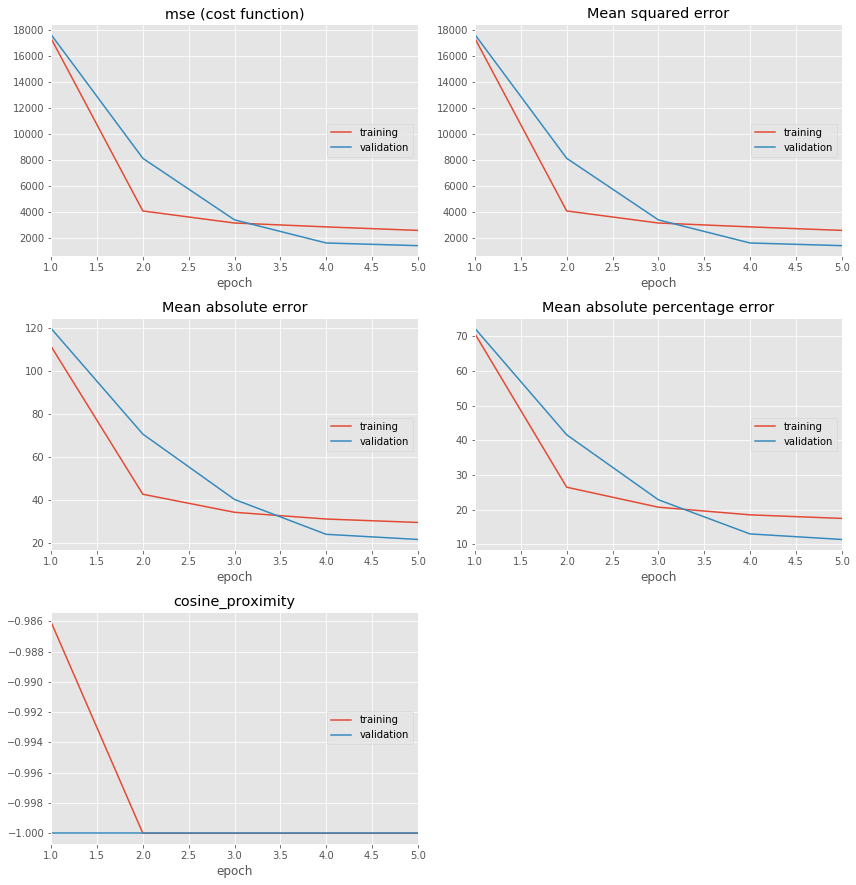

7610/7610 [==============================] - 2s - loss: 2588.7074 - mean_squared_error: 2588.7074 - mean_absolute_error: 29.5693 - mean_absolute_percentage_error: 17.5163 - cosine_proximity: -1.0000 - val_loss: 1416.4547 - val_mean_squared_error: 1416.4547 - val_mean_absolute_error: 21.6537 - val_mean_absolute_percentage_error: 11.4536 - val_cosine_proximity: -1.0000


In [86]:
regressor.fit(trainX,
    y_train,
    batch_size=24,
    epochs=5,
    validation_split=0.3,
    callbacks=[plot_losses])

In [11]:
y_pred=regressor.predict(testX)

In [12]:
wyniki = pd.DataFrame()
wyniki['Actual']= y_test[:264]
wyniki['predicted']= y_pred[:264]
wyniki.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki['index']=range(len(wyniki))

In [13]:
wyniki[-264:]

,Actual,predicted,index
Data godzina,,,
15-04-18 1:00,159.49,158.006714,0
15-04-18 2:00,157.54,151.395752,1
15-04-18 3:00,155.00,148.834152,2
15-04-18 4:00,154.39,147.926559,3
15-04-18 5:00,150.00,148.376572,4
15-04-18 6:00,150.00,147.317474,5
15-04-18 7:00,142.70,148.147522,6
15-04-18 8:00,146.19,156.402634,7
15-04-18 9:00,160.58,168.935486,8


<IPython.core.display.Javascript object>


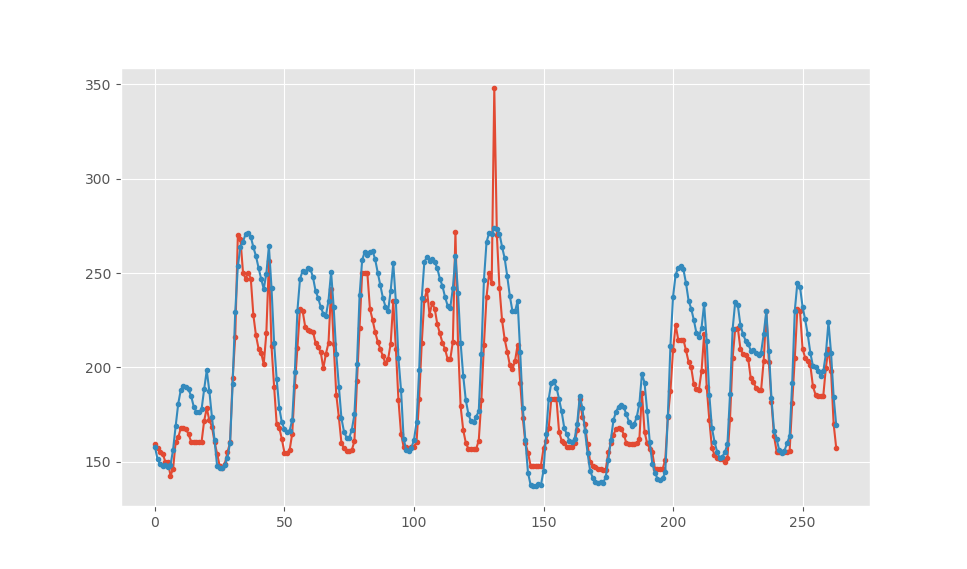

In [14]:
%matplotlib notebook
plt.style.use('ggplot')
plt.figure()
plt.plot(wyniki['index'],wyniki['Actual'],marker='.')## Czerwone kropki to obserwacje za ostatnie 11 dni, niebieskie to prognoza
plt.plot(wyniki['index'],wyniki['predicted'],marker='.',) 

In [15]:
prediction= regressor.predict(testX[-24:])  ## -24 ostatnie obserwacje w testowym to dzień t+1##

In [16]:
dates2 = pd.date_range(start='2018-04-26 01:00',end='2018-04-27 00:00',freq='1h') 
for i in range(0,24):
    dates2[i]

In [17]:
prognoza24h=pd.DataFrame(data=prediction,          ##tutaj prognoza na jutro#      
...              index=dates2,    
...              columns=['prognoza'])  
prognoza24h

,prognoza
2018-04-26 01:00:00,157.761398
2018-04-26 02:00:00,154.918442
2018-04-26 03:00:00,153.466446
2018-04-26 04:00:00,153.617630
2018-04-26 05:00:00,155.767517
2018-04-26 06:00:00,157.133591
2018-04-26 07:00:00,183.484818
2018-04-26 08:00:00,214.644516
2018-04-26 09:00:00,229.712051
2018-04-26 10:00:00,231.322586


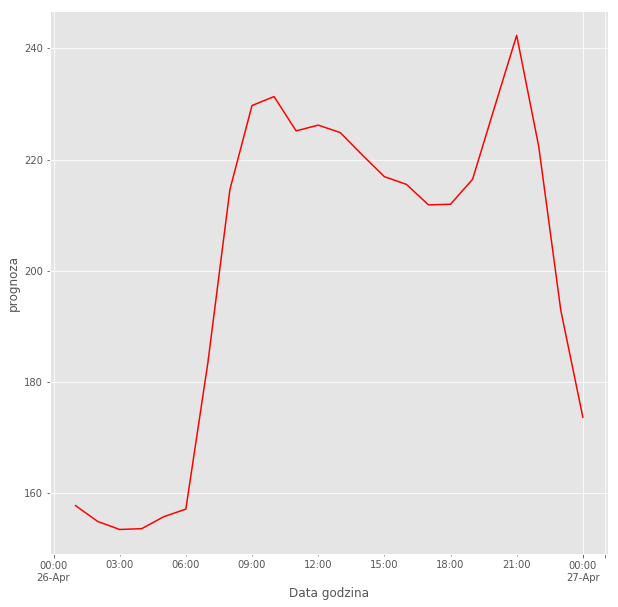

In [18]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')


prognoza24h['prognoza'].plot(figsize=(10,10),color='red')
plt.xlabel('Data godzina')
plt.ylabel('prognoza')
plt.show()

In [19]:
base=prognoza24h.mean()## tutaj BASE##
print(base)

prognoza    200.925858
dtype: float32


In [20]:
prognoza24h.std() ## odchylenie standardowe##

prognoza    30.652973
dtype: float32

In [21]:
peak1=prognoza24h.sort_index().loc[prognoza24h.index[[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]]  ## tutaj peak ##
peak1.mean()
print(peak1)
print(peak1.mean())##PEAK pod szeregiem##
peak=peak1.mean()

                       prognoza
2018-04-26 08:00:00  214.644516
2018-04-26 09:00:00  229.712051
2018-04-26 10:00:00  231.322586
2018-04-26 11:00:00  225.152054
2018-04-26 12:00:00  226.184204
2018-04-26 13:00:00  224.850876
2018-04-26 14:00:00  220.811813
2018-04-26 15:00:00  216.923111
2018-04-26 16:00:00  215.532761
2018-04-26 17:00:00  211.850204
2018-04-26 18:00:00  211.956131
2018-04-26 19:00:00  216.443832
2018-04-26 20:00:00  229.439896
2018-04-26 21:00:00  242.339111
2018-04-26 22:00:00  222.348129
prognoza    222.634064
dtype: float32


In [22]:
basepeak2=pd.DataFrame(data=peak,
                      index=None,
                      columns=['peak'])
basepeak1=pd.DataFrame(data=base,
                index=None,
                columns=['base'])
tabelka1= basepeak1.combine_first(basepeak2)
tabelka1

,base,peak
prognoza,200.925858,222.634064


In [23]:
from sklearn.metrics import r2_score   #tutaj błędy modelu na zbiorze testowym  tego 99%##
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki['Actual'],wyniki['predicted'])
msle=mean_squared_log_error(wyniki['Actual'],wyniki['predicted'])
mse=mean_squared_error(wyniki['Actual'],wyniki['predicted'])
mae=mean_absolute_error(wyniki['Actual'],wyniki['predicted'])
evs=explained_variance_score(wyniki['Actual'],wyniki['predicted'])
medianae=median_absolute_error(wyniki['Actual'],wyniki['predicted'])
rmse=sqrt(mean_squared_error(wyniki2['Actual'],wyniki2['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','rmse'],[r,msle,mse,mae,evs,medianae,rmse]],dtype='U25')
df = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy2=df.drop(0)
Bledy2.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error
1,0.6426069838142843,0.008282454677473605,384.3339969468993,16.00934358770197,0.8157669463967531,14.092509460449222


<IPython.core.display.Javascript object>


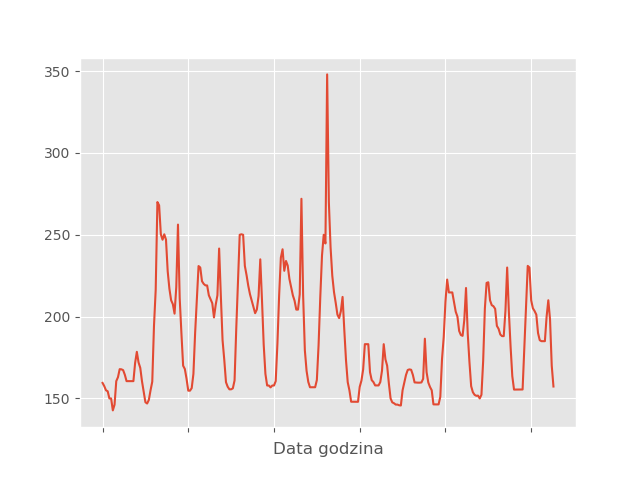

count    264.000000
mean     186.701705
std       32.855302
min      142.700000
25%      157.960000
50%      182.635000
75%      210.037500
max      348.000000
Name: RDN 1fix, dtype: float64

In [24]:
z=y_test[:264]
%matplotlib notebook 
z.plot.line()
z.describe()  ## Średnia - mean cena za ostatnich 11 dni, odch stand., minimalna, maksymalna, 25%, mediana, 75% i maksymalna cena za ost 11 dni

<IPython.core.display.Javascript object>


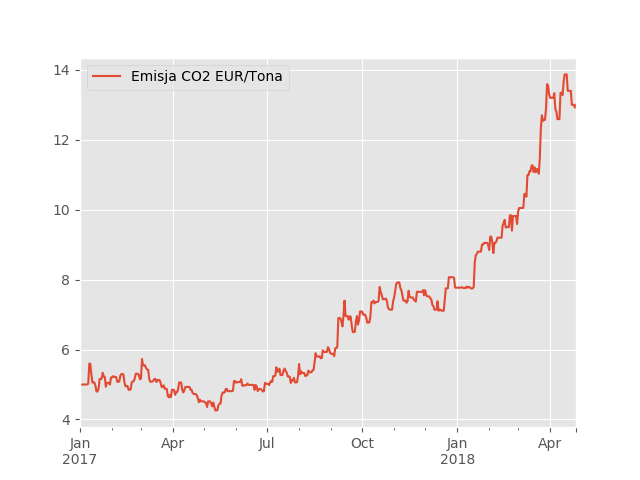

In [61]:
g=indeks['Emisja CO2 EUR/Tona'].groupby(np.arange(len(indeks))//24).mean()  ## tutaj na dole wykres z CO2 z EEX
dates = pd.date_range(start='2017-01-01',end='2018-04-26',freq='1d')
for i in range(0,448):
    dates[i]
c=np.asarray(g)
co2=pd.DataFrame(data=c,
                index=dates,
                columns=['Emisja CO2 EUR/Tona'])
%matplotlib notebook
co2.plot()
plt.show()

In [25]:
from bokeh.plotting import figure, output_notebook, show
p = figure(plot_width=1000, plot_height=500, tools="pan,box_zoom,reset,save",x_axis_type="linear", y_axis_type="linear")



p.line(wyniki['index'],wyniki['Actual'],alpha=0.9,legend="Obserwacja",color='blue')
p.line(wyniki['index'],wyniki['predicted'],alpha=0.8,legend="Prognoza",color="red")

output_notebook()

##
show(p)

Loading BokehJS ...